In [6]:
#---- to do list -----
# err_data_list 파일자동화
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
np.set_printoptions(suppress=True)

#pow 낮값만 추출 test
#pow = 0인 구간 : 0~4, 21-23시
powhr_start = 5
powhr_end   = 20

shift_days  = 3
hoursteps   = powhr_end-powhr_start+1 #(16)
timesteps   = shift_days*hoursteps #hours step

data_dim    = 15
out_dim     = 1

n_model    = 10

save_name = '210504'

season_mod = 'all_1030_5'
date_start = '10100901'
date_end   = '30191201'

err_date_list = ['20190912',
                    '20191122',
                    '20191130',
                    '20191217',
                    '20200501',
                    '20200502',
                    '20191028',
                    '20191107',
                    '20191108',
                    '20191109',
                    '20191110',
                    '20191111',
                    '20191112',
                    '20200214',
                    '20200307',
                    '20200308',
                    '20200309',
                    '20200310',
                    '20200328',
                    '20200329',
                    '20200625',
                    '20200809','20201003','20201029','20201226','20201227','20201228','20201229']

# Yeo-JohnsonTransformer

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 

transf_type = 'yeo-johnson'
#transf_type = 'box-cox'

def yeo_johnson_transform(dataset):
    
    column_trans = ColumnTransformer(
                    [('sunshine', PowerTransformer(method=transf_type, standardize=True), ['sunshine']),
                     ('humdt', PowerTransformer(method=transf_type, standardize=True), ['humdt']),
                     ('wnd_spd', PowerTransformer(method=transf_type, standardize=True), ['wnd_spd']),
                     ('visiblt', PowerTransformer(method=transf_type, standardize=True), ['visiblt']),
                     ('cloud2', PowerTransformer(method=transf_type, standardize=True), ['cloud2']),
                     ('cloud', PowerTransformer(method=transf_type, standardize=True), ['cloud']),
                     ('grd_temprt', PowerTransformer(method=transf_type, standardize=True), ['grd_temprt']),
                     ('wnd_dir', PowerTransformer(method=transf_type, standardize=True), ['wnd_dir']),
                     ('dewpnt', PowerTransformer(method=transf_type, standardize=True), ['dewpnt']),
                     ('steampressr', PowerTransformer(method=transf_type, standardize=True), ['steampressr']),
                     ('temprt', PowerTransformer(method=transf_type, standardize=True), ['temprt']),
                     ('mincloud', PowerTransformer(method=transf_type, standardize=True), ['mincloud']),
                     ('rain', PowerTransformer(method=transf_type, standardize=True), ['rain']),
                     ('pressr', PowerTransformer(method=transf_type, standardize=True), ['pressr']),
                     ('seapressr', PowerTransformer(method=transf_type, standardize=True), ['seapressr']),
                     ('snow', PowerTransformer(method=transf_type, standardize=True), ['snow'])
                    ])
    
    transformed_data = column_trans.fit_transform(dataset)
    transformed_df = pd.DataFrame(transformed_data, columns=dataset.columns)
    pd.concat([transformed_df], axis = 1)
                    
    return transformed_df

# Get weather, pow data

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
from pandas import read_csv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 
#from feature_engine import variable_transformers as vt
from scipy.stats import yeojohnson

load_path = 'C:/solar/pow_24/'
save_path = 'C:/Users/VISLAB_PHY/Desktop/D_WORKSPACE/Data/'
save_name = '210504'

#############################################
# 태양광 전력
#############################################
def get_pow():

    # pow 파일 load
    dir_path = 'C:/solar/pow_24/UR00000126_csv'
    file_list   = os.listdir(dir_path)
    print(len(file_list))
    hrPow  = []    

    # pow측정값 에러가 큰 일자 제거
    for filename in file_list:
        if (filename[:-4] not in err_date_list):
            if ((filename[:-4]>=date_start) & (filename<date_end)):
                filedata = pd.read_csv(dir_path+'/'+filename).values[:,0]
                hrPow.append(filedata)
                #print(filename[:-4])
                
    #낮시간 추출 (5~20시)
    pow_dataset = pd.DataFrame(hrPow)
    pow_dataset =pow_dataset.iloc[:,powhr_start:powhr_end+1]
    #pow_dataset.to_csv("C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/data/pow_hr.csv",mode='w',index=False)

    # 결측값 보간, reshape
    pow_dataset = pow_dataset.interpolate(method='linear')
    pow_dataset = pow_dataset.values.reshape(-1,1)
    pow_dataset = pd.DataFrame(pow_dataset)
    pow_dataset.columns = ['pow']
    pow_dataset.to_csv(save_path+"/pow_"+save_name+".csv",mode='w',index=False)

    
    # scale
    sc_pow = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = sc_pow.fit_transform(pow_dataset.values)
    df_pow = pd.DataFrame(scaled_pow, columns=pow_dataset.columns, index=list(pow_dataset.index.values))
    
    return df_pow, sc_pow

#############################################
# 종관기상관측
#############################################
def get_weather():
    # pow 파일 load
    file_list   = os.listdir(load_path)
    print(len(file_list))
    for filename in os.listdir(load_path):
        if fnmatch.fnmatch(filename, 'OBS_ASOS_TIM_*.csv'):
            print(filename)

            # load csv data
            dataset = read_csv(load_path+'/'+filename, encoding='CP949')
            dataset.drop(['지점','지점명'], axis=1, inplace=True)
            dataset.drop(['기온 QC플래그','강수량 QC플래그','풍속 QC플래그','풍향 QC플래그','습도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['현지기압 QC플래그','해면기압 QC플래그','일조 QC플래그','지면온도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['5cm 지중온도(°C)','10cm 지중온도(°C)','20cm 지중온도(°C)','30cm 지중온도(°C)'], axis=1, inplace=True)
            dataset.drop(['3시간신적설(cm)','일사(MJ/m2)','운형(운형약어)','지면상태(지면상태코드)','현상번호(국내식)'], axis=1, inplace=True)

            # set column name
            dataset.columns = ['ymdhms', 'temprt', 'rain', 'wnd_spd', 'wnd_dir', 'humdt','steampressr',
                               'dewpnt', 'pressr','seapressr','sunshine','snow','cloud','cloud2','mincloud','visiblt','grd_temprt']

            # prioirty sort (피어슨상관계수)
            dataset = dataset[['ymdhms','sunshine','humdt','wnd_spd','visiblt','cloud2',
                               'cloud','grd_temprt','wnd_dir','dewpnt','steampressr','temprt',
                               'mincloud','rain','pressr','seapressr','snow']]


            # set NA data (관측값 0이 누적되어 결측된 경우. 0으로 세팅)
            dataset['rain'].fillna(0, inplace=True)     #강수량
            dataset['sunshine'].fillna(0, inplace=True) #일조
            dataset['snow'].fillna(0, inplace=True)     #적설량

            #일시 패턴 변환(2019-08-20 5:00 -> 2019082005)
            dataset['ymdhms'] = dataset['ymdhms'].str[0:4]+dataset['ymdhms'].str[5:7]+dataset['ymdhms'].str[8:10]+dataset['ymdhms'].str[-5:-4].replace(" ","0")+dataset['ymdhms'].str[-4:-3]
            # pow측정값 중 결측값 많은 일자 제거
            dataset = dataset[(dataset['ymdhms'].str[0:8]>=date_start) & (dataset['ymdhms'].str[0:8]<date_end)]
            for err_date in err_date_list:
                idx_err = dataset[dataset['ymdhms'].str.startswith(err_date)].index
                dataset = dataset.drop(idx_err)

            #낮시간 추출 (5~20시)
            dataset = dataset[(dataset['ymdhms'].str[-2:]>=str(powhr_start).rjust(2, '0')) &(dataset['ymdhms'].str[-2:]<=str(powhr_end))]
            dataset = dataset.interpolate(method='linear')# 결측값 보간
            
            # save file (test용)
            dataset.to_csv(save_path+"/weather_"+save_name+".csv",mode='w',index=False)

            # normalization
            dataset.drop(['ymdhms'], axis=1, inplace=True)
            dataset = dataset.astype('float32')
            dataset = dataset.interpolate(method='linear')
            
            #YEO-JOHNSON transform
            #yeo_df = yeo_johnson_transform(dataset)
            yeo_df = dataset
            #insert feature (test)
            yeo_df.insert(2, 'temp_press', yeo_df['temprt']-yeo_df['steampressr'], True)
            yeo_df.insert(2, 'sunshine_humdt', abs(yeo_df['sunshine'])-(yeo_df['humdt']*(2.1)), True)#0.35
            
            sc = MinMaxScaler(feature_range = (0, 1))#scale
            scaled_weather = sc.fit_transform(yeo_df.values)
            weather = pd.DataFrame(scaled_weather, columns=yeo_df.columns, index=list(yeo_df.index.values))
            
            weather = weather.iloc[:, 0:data_dim] #feature size 조절
            
    return weather


# Numpy data
weather, pow

In [9]:
#############################################
# numpy data 만들기
#############################################

df_pow, sc_pow   = get_pow()
df               = get_weather()

print("df_pow : ", df_pow.shape)
print("df : ",df.shape)

# pow + weather + powY
df.insert(0, 'pow', df_pow.values, True)
df = df.iloc[0:-timesteps, :]
df.insert(df.shape[1], 'pow_Y', df_pow.iloc[timesteps:, :].values, True)

df.to_csv(save_path+"/total_"+save_name+".csv",mode='w',index=False, encoding='CP949')


550
13
OBS_ASOS_TIM_20190820_20210313.csv
df_pow :  (8704, 1)
df :  (8704, 15)


In [10]:
#dir_path = 'C:/Users/VISLAB_PHY/Desktop/D_WORKSPACE/Data/'
#df = read_csv(dir_path+'total.csv', encoding='CP949')
#----------------------------------------------
# time step만큼 window 움직여 dataset 생성
#----------------------------------------------
totalsize = df.shape[0]
dataX, dataY = [], []

for i in range(0, totalsize-timesteps-24+1, hoursteps):
    dataX.append(df.iloc[i:(i + timesteps),0:-1])
    dataY.append(df.iloc[i:(i + hoursteps),[0]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

#----------------------------------------------
#  Split train/test 
#----------------------------------------------

train_size = int(len(dataX) * 0.7)
val_size   = int(len(dataX) * 0.2)
test_size  = len(dataX) - train_size - val_size
val_idx = train_size+val_size

trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, '\tY : ', trainY.shape)
print('val   X : ', valX.shape,   '\tY : ', valY.shape)
print('test  X : ', testX.shape,  '\tY : ', testY.shape)

np.save("npset/"+season_mod+"_trainX",trainX)
np.save("npset/"+season_mod+"_trainY",trainY)
np.save("npset/"+season_mod+"_valX",valX)
np.save("npset/"+season_mod+"_valY",valY)
np.save("npset/"+season_mod+"_testX",testX)
np.save("npset/"+season_mod+"_testY",testY)


# 모델 1

len(dataX) :  537 (48, 16)
len(dataY) :  537 (16, 1)
train X :  (375, 48, 16) 	Y :  (375, 16, 1)
val   X :  (107, 48, 16) 	Y :  (107, 16, 1)
test  X :  (55, 48, 16) 	Y :  (55, 16, 1)


In [11]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(tf.keras.layers.RepeatVector(data_dim+1))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               279552    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 16, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 256)           65792     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 1)             257       
Total params: 870,913
Trainable params: 870,913
Non-trainable params: 0
_________________________________________________________________


# 모델 fit 반복돌리기
range 바꾸기

In [ ]:
for i in range(n_model):#0,5):#

    #keras.optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_error', 
                  optimizer=RMSProp()
                  #optimizer=RMSProp(learning_rate=0.001)
                  #optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
                  #metrics=['acc'])
                 )

    hist = model.fit(trainX, 
                     trainY, 
                     epochs=200, 
                     batch_size=64,
                     validation_data=(valX, valY))


    results = model.evaluate(testX, testY)
    #model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

    model.save('model/model_'+save_name+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18

# trainX 학습과정

In [ ]:

# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

fig, loss_ax = plt.subplots()
loss_ax.grid()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')
plt.show()
print('result : ', results)

In [ ]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)

step = hoursteps*30
for i in range(0, plotY.shape[0]-step, step):
#for i in range(0, 240-step, step):
    plt.rcParams["figure.figsize"] = (25,4)
    plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
    plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid()
    plt.legend()
    plt.show()

#print(plotY_pred)

In [ ]:

plt.rcParams['font.size'] = 20
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
#pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plotY_pred = x.reshape(-1,1)

acc_list = []
target_list=[]

step = hoursteps*21
for i in range(0, plotY.shape[0]-step, step):
#for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
#for i in range(0, 240-step, step):
    plt.rcParams["figure.figsize"] = (30,4)
    plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
    plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid()
    plt.legend()
    plt.show()

#plt.tight_layout()
plt.savefig(save_path+'/predict.jpg')
#plt.show()
#print(plotY_pred)

In [ ]:
print(y.shape)
print(y)
print(hoursteps)

In [ ]:
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

err_list = []
target_list=[]
predErrRate_list = []

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.plot(plotY[i:i+hoursteps], 'r-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'y-', label="output")
    print("******************** i : ", i)
    for hr in range(0, hoursteps):
        pred   = plot_pred[i+hr]
        target = plotY[i+hr]
        difference = np.abs(target-pred)
        predErrRate = np.round(difference/173000*100, 2)
        
        #print("|t:",target,"-p:",pred,"|=",err,",예측오차율:",predErrRate)
        err_list.append(err)
        predErrRate_list.append(predErrRate)
    
    target_list.append(target)
    acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

In [ ]:
print("test data : ", np.rint(np.shape(predErrRate_list)[0]/24),"일 (", np.shape(predErrRate_list)[0],"시간)",)
print("mean(err rate): ",np.round(np.mean(predErrRate_list),3),sep='')
print(" max(err rate): ",np.max(predErrRate_list),sep='')

#plotAcc = np.array(acc_list).reshape(-1,1)
plt.rcParams["figure.figsize"] = (15,6)
plt.title("predErrRate")
plt.xlabel('시간(hr)')
plt.ylabel('예측오차율(%)')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
#plt.ylim(0,10)
plt.plot(predErrRate_list, 'g-')
plt.grid(True)
plt.show()
#print(predErrRate_list)

In [ ]:
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
#pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

acc_list = []
target_list=[]
predErrRate_list = []

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.plot(plotY[i:i+hoursteps], 'r-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'y-', label="output")
    #plt.legend()
    #plt.show()
    
    pred = np.sum(plot_pred[i:i+hoursteps])
    target      = round(np.sum(plotY[i:i+hoursteps]), 2)
    
    error       = round(np.abs(target-pred), 2)
    error_rate  = round(error/target, 2)
    acc_rate    = np.max([round((1.0-error_rate)*100, 2),0])
    
    
    predErrRate = round(np.abs((target-pred)/920.2*100), 2)
    predErrRate_list.append(predErrRate)
    
    target_list.append(target)
    acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

mean(acc rate): 92.2927807486631


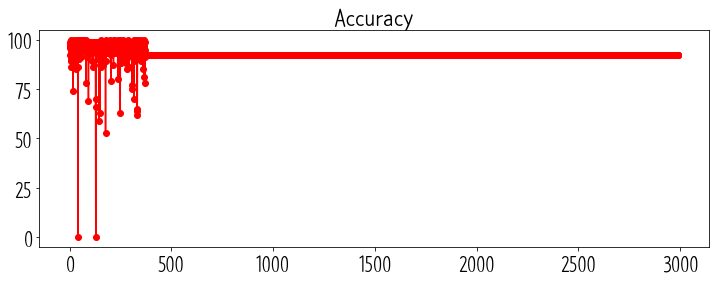

[99.0, 92.0, 97.0, 98.0, 96.0, 94.0, 100.0, 86.0, 90.0, 89.0, 96.0, 98.0, 94.0, 91.0, 92.0, 88.0, 96.0, 99.0, 74.0, 93.0, 98.0, 97.0, 98.0, 99.0, 100.0, 94.0, 97.0, 99.0, 96.0, 97.0, 98.0, 92.0, 85.0, 92.0, 99.0, 99.0, 100.0, 98.0, 96.0, 91.0, 94.0, 86.0, 0.0, 98.0, 98.0, 100.0, 99.0, 90.0, 100.0, 97.0, 97.0, 100.0, 98.0, 99.0, 99.0, 95.0, 100.0, 96.0, 91.0, 98.0, 100.0, 99.0, 95.0, 95.0, 95.0, 98.0, 99.0, 97.0, 99.0, 99.0, 98.0, 99.0, 100.0, 98.0, 94.0, 96.0, 99.0, 95.0, 97.0, 98.0, 98.0, 78.0, 97.0, 100.0, 99.0, 97.0, 98.0, 98.0, 91.0, 96.0, 98.0, 99.0, 98.0, 69.0, 94.0, 97.0, 99.0, 99.0, 95.0, 97.0, 97.0, 97.0, 93.0, 97.0, 99.0, 96.0, 98.0, 95.0, 94.0, 97.0, 95.0, 96.0, 89.0, 96.0, 94.0, 99.0, 95.0, 86.0, 95.0, 98.0, 95.0, 95.0, 95.0, 99.0, 98.0, 96.0, 95.0, 96.0, 66.0, 0.0, 70.0, 93.0, 97.0, 95.0, 93.0, 93.0, 93.0, 99.0, 96.0, 94.0, 98.0, 90.0, 95.0, 97.0, 59.0, 98.0, 95.0, 91.0, 94.0, 63.0, 87.0, 91.0, 93.0, 86.0, 95.0, 100.0, 97.0, 98.0, 99.0, 99.0, 98.0, 98.0, 98.0, 99.0, 98.0, 

In [113]:
print("mean(acc rate): ",np.mean(acc_list),sep='')
    
#plotAcc = np.array(acc_list).reshape(-1,1)
plt.plot(acc_list, 'ro-')
plt.title("Accuracy")
plt.show()
print(acc_list)

# model들 acc 평균 출력

In [114]:

from tensorflow.keras.models import load_model

mod = 'summer'

#get test data
X_test = np.load("npset/"+season_mod+"_testX.npy")
y_test = np.load("npset/"+season_mod+"_testY.npy")

#get pow scale form
#powdata, scaler = libs_yeon.get_pow()

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
predictModel = []

for i in range(n_model):
    predictModel.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))
    acc_model.append(0)
    
print("[ dataset ]")
for i in range(n_dataset):
    #if(i in [2,3,4,5,6,7,8]): continue;
    y = sc_pow.inverse_transform(y_test[i:i+1,:,0])

    for m in range(n_model):
        #print("(model",m+1,")\t",end="")

        pred = predictModel[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = sc_pow.inverse_transform(pred)
        pred = np.sum(pred)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-pred), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        acc_model[m] += acc_rate
                 
        #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
        
    #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
    print(np.mean(acc_list[-n_model:]), " / ",sep='', end='')
        
print("\n----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
for i in range(n_model):
    acc_model[i] = round(acc_model[i]/(n_dataset),2)
    print(acc_model[i])

X_test :  (55, 48, 16)
y_test :  (55, 16, 1)
[ dataset ]
74.9 / 87.6 / 83.2 / 78.6 / 69.7 / 94.3 / 95.9 / 55.4 / 85.4 / 95.1 / 78.3 / 36.7 / 47.4 / 93.2 / 91.3 / 10.3 / 94.7 / 86.9 / 91.8 / 88.7 / 85.0 / 11.6 / 91.8 / 91.6 / 97.0 / 60.2 / 93.3 / 93.4 / 94.1 / 95.3 / 88.1 / 81.1 / 81.3 / 93.7 / 64.5 / 81.0 / 77.6 / 85.7 / 91.8 / 89.0 / 83.9 / 89.5 / 94.1 / 91.4 / 60.4 / 54.9 / 91.5 / 95.6 / 65.5 / 55.0 / 79.7 / 78.3 / 20.8 / 89.9 / 90.2 / 
----------------------------------------------
mean(acc rate): 78.67636363636363
----------------------------------------------
[ model ]
83.02
85.62
82.42
78.15
76.96
72.47
78.49
73.55
77.02
79.07
